In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]


import sys
sys.path.append('../../')

In [2]:
from keras.preprocessing import image
import numpy as np

from src.classifier import TLClassifier
from src.utilities import load_dataset_from_path, UIUC_EVENT_CLASS, CODALAB_GENDER_CLASS, CODALAB_SMILE_CLASS, KAGGLE_DOGCAT_CLASS
from src.plots import plot_confusion_matrix

Using TensorFlow backend.


# Codalab Smile

In [3]:
# Codalab Smile 2 classes
# VGG16 bottleneck path
vgg16_model = TLClassifier('vgg16', 2, 'codalab/224_224/model/smile/vgg16/checkpoint/improved-018-0.73.hdf5')
inception_model = TLClassifier('inceptionv3', 2, 'codalab/224_224/model/smile/inceptionv3/checkpoint/improved-117-0.73.hdf5')
resnet50_model = TLClassifier('resnet50', 2, 'codalab/224_224/model/smile/resnet50/checkpoint/improved-074-0.76.hdf5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


../../src/utilities.py:325: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  output=top_model(base_model.output))


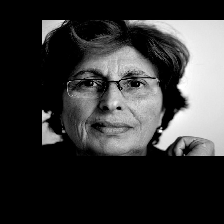

In [4]:
# Example image
codalab_1_path = '../data/codalab/im_GenFex_06173.jpg'
codalab_1_img = image.load_img(codalab_1_path, target_size=(224, 224))
codalab_1 = image.img_to_array(codalab_1_img)
codalab_1 = np.expand_dims(codalab_1, axis=0)
codalab_1_img

In [5]:
from sklearn.metrics.classification import accuracy_score, confusion_matrix

print(vgg16_model.predict(codalab_1))
print(inception_model.predict(codalab_1))
print(resnet50_model.predict(codalab_1))

[[ 0.98905808  0.01094193]]
[[ 0.96547717  0.03452285]]
[[ 0.93086159  0.06913843]]


## Predicting with 3 models

In [ ]:
val_data_path = 'codalab/224_224/val_data.npz'
val_label_path = 'codalab/224_224/val_smile_label.npz'
val_data = load_dataset_from_path(val_data_path)
val_label = load_dataset_from_path(val_label_path)
metrics = [accuracy_score, confusion_matrix]

vgg16_preds = vgg16_model.predict(val_data)
vgg16_y = np.argmax(vgg16_preds, axis=1)
vgg16_scores = vgg16_model.evaluate_metrics(vgg16_y, val_label, metrics)

inception_preds = inception_model.predict(val_data)
inception_y = np.argmax(inception_preds, axis=1)
inception_scores = inception_model.evaluate_metrics(inception_y, val_label, metrics)

resnet50_preds = resnet50_model.predict(val_data)
resnet50_y = np.argmax(resnet50_preds, axis=1)
resnet50_scores = resnet50_model.evaluate_metrics(resnet50_y, val_label, metrics)

In [ ]:
vgg16_scores, inception_scores, resnet50_scores

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams['font.size'] = 12
plot_confusion_matrix(plt, vgg16_scores[1], CODALAB_SMILE_CLASS.values(), title='Codalab Smile - VGG16')
plot_confusion_matrix(plt, inception_scores[1], CODALAB_SMILE_CLASS.values(), title='Codalab Smile - Inception V3')
plot_confusion_matrix(plt, resnet50_scores[1], CODALAB_SMILE_CLASS.values(), title='Codalab Smile - ResNet50')

## Misclassified but has high confidence

In [ ]:
from PIL import ImageFont
from PIL import ImageDraw

font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf",17)

def wrong_class_high_probs(arc_y, arc_preds, val_label, n=10):
    # Get all the wrong classified images
    wrong_idx = np.where(arc_y != val_label)
    # Get the probs of these wrong classified images
    wrong_idx_max_probs = arc_preds[wrong_idx]
    # Sort based on those probabilities
    wrong_idx_probs_sorted = np.argsort(wrong_idx_max_probs)[::-1][:n]
    # Get the actual index of the images on wrong_idx
    sorted_wrong_idx = wrong_idx[0][wrong_idx_probs_sorted]
    return (sorted_wrong_idx, val_label[sorted_wrong_idx], arc_preds[sorted_wrong_idx], wrong_idx_max_probs[wrong_idx_probs_sorted.tolist()])

def draw_stats(img_array, true_label, pred_label, pred_prob):
    im = image.array_to_img(img_array)
    draw = ImageDraw.Draw(im)
    draw.text((0, 0),'True: %s, Pred: %s \nProb: %s' % (CODALAB_SMILE_CLASS[int(true_label)], CODALAB_SMILE_CLASS[pred_label], pred_prob),(0,255,0),font=font)
    draw = ImageDraw.Draw(im)
    return im

In [ ]:
# Get all 10 images from VGG16
vgg16_sorted_wrong_idx, vgg16_true_labels, vgg16_pred_labels, vgg16_pred_probs = wrong_class_high_probs(vgg16_y, vgg16_preds, val_label, n=20) 
# Draw the images
for idx, wrong_idx in enumerate(vgg16_sorted_wrong_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[wrong_idx], val_label[wrong_idx], vgg16_y[wrong_idx], vgg16_pred_probs[idx]))

In [ ]:
# Inceptionv3
inception_sorted_wrong_idx, inception_true_labels, inception_pred_labels, inception_pred_probs = wrong_class_high_probs(inception_y, inception_preds, val_label, n=20) 
# Draw the images
for idx, wrong_idx in enumerate(inception_sorted_wrong_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[wrong_idx], val_label[wrong_idx], inception_y[wrong_idx], inception_pred_probs[idx]))


In [ ]:
# resnet50
resnet50_sorted_wrong_idx, resnet50_true_labels, resnet50_pred_labels, resnet50_pred_probs = wrong_class_high_probs(resnet50_y, resnet50_preds, val_label, n=20) 
# Draw the images
for idx, wrong_idx in enumerate(resnet50_sorted_wrong_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[wrong_idx], val_label[wrong_idx], resnet50_y[wrong_idx], resnet50_pred_probs[idx]))


## Classified true but has low confidence

In [ ]:
def right_class_low_probs(arc_y, arc_preds, val_label, n=10):
    # Get all the right classified images
    right_idx = np.where(arc_y == val_label)
    # Get the max probabilities (the max output of the 3 output neurons) of these right classified images
    right_idx_max_probs = np.max(arc_preds[right_idx], axis=1)
    # Sort based on those probabilities - ascending, get the first n
    right_idx_probs_sorted = np.argsort(right_idx_max_probs)[:n]
    # Get the actual index of the images on right_idx
    sorted_right_idx = right_idx[0][right_idx_probs_sorted]
    return (sorted_right_idx, val_label[sorted_right_idx], arc_preds[sorted_right_idx], right_idx_max_probs[right_idx_probs_sorted.tolist()])


In [ ]:
# Get all 10 images from VGG16
vgg16_right_sorted_idx, vgg16_right_true_labels, vgg16_right_pred_labels, vgg16_right_pred_probs = right_class_low_probs(vgg16_y, vgg16_preds, val_label, n=20) 
# Draw the images
for idx, right_idx in enumerate(vgg16_right_sorted_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[right_idx], val_label[right_idx], vgg16_y[right_idx], vgg16_right_pred_probs[idx]))

In [ ]:
# Inception
inception_right_sorted_idx, inception_right_true_labels, inception_right_pred_labels, inception_right_pred_probs = right_class_low_probs(inception_y, inception_preds, val_label, n=20) 
# Draw the images
for idx, right_idx in enumerate(inception_right_sorted_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[right_idx], val_label[right_idx], inception_y[right_idx], inception_right_pred_probs[idx]))

In [ ]:
# Resnet50
resnet50_right_sorted_idx, resnet50_right_true_labels, resnet50_right_pred_labels, resnet50_right_pred_probs = right_class_low_probs(resnet50_y, resnet50_preds, val_label, n=20) 
# Draw the images
for idx, right_idx in enumerate(resnet50_right_sorted_idx.tolist()):
    plt.figure()
    plt.axis('off')
    plt.imshow(draw_stats(val_data[right_idx], val_label[right_idx], resnet50_y[right_idx], resnet50_right_pred_probs[idx]))